In [4]:
import matplotlib.pyplot as plt
import tensorflow as tf

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

from pathlib import Path

IMAGES_PATH = Path() / "images" / "rnn"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)




Basic RNNs- Recurrent Neural Network


108512/108512 [==============================] - 0s 0us/step
           day_type     bus    rail
date                               
2001-01-01        U  297192  126455
2001-01-02        W  780827  501952
2001-01-03        W  824923  536432
2001-01-04        W  870021  550011
2001-01-05        W  890426  557917


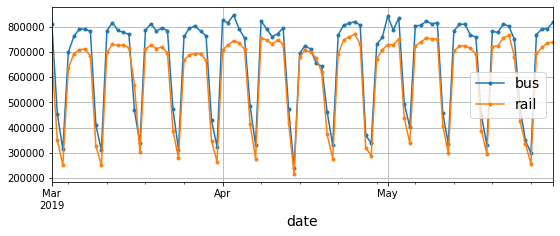

In [5]:
tf.keras.utils.get_file(
    "ridership.tgz",
    "https://github.com/ageron/data/raw/main/ridership.tgz",
    cache_dir=".",
    extract=True
)
import pandas as pd
from pathlib import Path

path = Path("datasets/ridership/CTA_-_Ridership_-_Daily_Boarding_Totals.csv")
df = pd.read_csv(path, parse_dates=["service_date"])
df.columns = ["date", "day_type", "bus", "rail", "total"]  # shorter names
df = df.sort_values("date").set_index("date")
df = df.drop("total", axis=1)  # no need for total, it's just bus + rail
df = df.drop_duplicates()  # remove duplicated months (2011-10 and 2014-07)
print(df.head())

import matplotlib.pyplot as plt

df["2019-03":"2019-05"].plot(grid=True, marker=".", figsize=(8, 3.5))
save_fig("daily_ridership_plot")  # extra code – saves the figure for the book
plt.show()

In [6]:
diff_7 = df[["bus", "rail"]].diff(7)["2019-03":"2019-05"]
diff_7


,bus,rail
date,,
2019-03-01,13927.0,-20019.0
2019-03-02,47280.0,21213.0
2019-03-03,25171.0,11672.0
2019-03-04,-63771.0,-45491.0
2019-03-05,-11268.0,-6517.0
...,...,...
2019-05-27,-482074.0,-464640.0
2019-05-28,-8578.0,-29490.0
2019-05-29,-20317.0,-38958.0


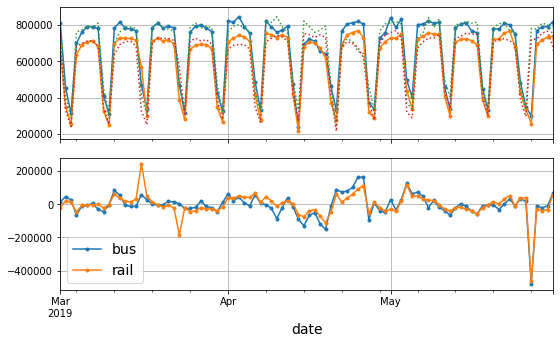

In [7]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 5))
df.plot(ax=axs[0], legend=False, marker=".")  # original time series
df.shift(7).plot(ax=axs[0], grid=True, legend=False, linestyle=":")  # lagged
diff_7.plot(ax=axs[1], grid=True, marker=".")  # 7-day difference time series
axs[0].set_ylim([170_000, 900_000])  # extra code – beautifies the plot
save_fig("differencing_plot")  # extra code – saves the figure for the book
plt.show()

In [8]:
diff_7.abs().mean()

bus     43915.608696
rail    42143.271739
dtype: float64

In [9]:
targets = df[["bus", "rail"]]["2019-03":"2019-05"]
(diff_7 / targets).abs().mean()

bus     0.082938
rail    0.089948
dtype: float64

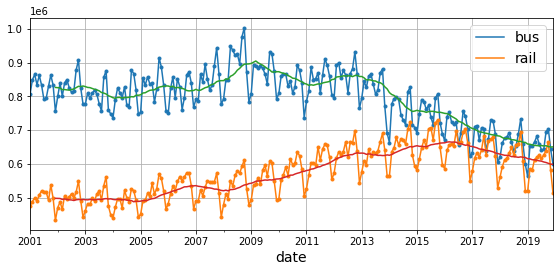

In [10]:
period = slice("2001", "2019")
df_monthly = df.resample('M').mean()  # compute the mean for each month
rolling_average_12_months = df_monthly[period].rolling(window=12).mean()

fig, ax = plt.subplots(figsize=(8, 4))
df_monthly[period].plot(ax=ax, marker=".")
rolling_average_12_months.plot(ax=ax, grid=True, legend=False)
save_fig("long_term_ridership_plot")  # extra code – saves the figure for the book
plt.show()

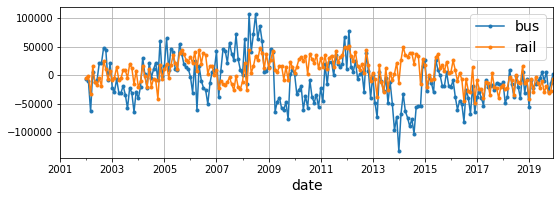

In [11]:
df_monthly.diff(12)[period].plot(grid=True, marker=".", figsize=(8, 3))
save_fig("yearly_diff_plot")  # extra code – saves the figure for the book
plt.show()

In [12]:
%pip install -q -U statsmodels

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 41.8 MB/s eta 0:00:00


In [13]:
from statsmodels.tsa.arima.model import ARIMA

origin, today = "2019-01-01", "2019-05-31"
rail_series = df.loc[origin:today]["rail"].asfreq("D")
model = ARIMA(rail_series,
              order=(1, 0, 0),
              seasonal_order=(0, 1, 1, 7))
model = model.fit()
y_pred = model.forecast()  # returns 427,758.6

In [14]:
y_pred

2019-06-01    427758.626313
Freq: D, dtype: float64

In [15]:
origin, start_date, end_date = "2019-01-01", "2019-03-01", "2019-05-31"
time_period = pd.date_range(start_date, end_date)
rail_series = df.loc[origin:end_date]["rail"].asfreq("D")
y_preds = []
for today in time_period.shift(-1):
    model = ARIMA(rail_series[origin:today],  # train on data up to "today"
                  order=(1, 0, 0),
                  seasonal_order=(0, 1, 1, 7))
    model = model.fit()  # note that we retrain the model every day!
    y_pred = model.forecast()[0]
    y_preds.append(y_pred)

y_preds = pd.Series(y_preds, index=time_period)
mae = (y_preds - rail_series[time_period]).abs().mean()  # returns 32,040.7

In [16]:
y_preds

2019-03-01    696955.515306
2019-03-02    342139.361018
2019-03-03    253320.415584
2019-03-04    633245.753166
2019-03-05    696723.448693
                  ...      
2019-05-27    736799.259388
2019-05-28    403824.542169
2019-05-29    721311.482982
2019-05-30    726614.005064
2019-05-31    699026.523594
Freq: D, Length: 92, dtype: float64

In [17]:
df["2019-03":"2019-05"]# original

,day_type,bus,rail
date,,,
2019-03-01,W,812238,682969
2019-03-02,A,454119,349392
2019-03-03,U,313539,252150
2019-03-04,W,699086,635353
2019-03-05,W,761781,692945
...,...,...,...
2019-05-27,U,298987,256757
2019-05-28,W,769069,694292
2019-05-29,W,791059,717681


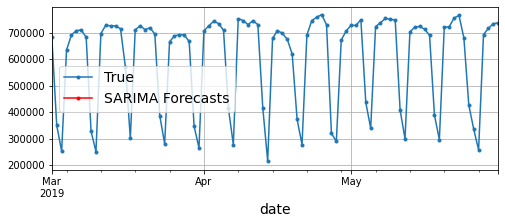

In [18]:
# extra code – displays the SARIMA forecasts
fig, ax = plt.subplots(figsize=(8, 3))
rail_series.loc[time_period].plot(label="True", ax=ax, marker=".", grid=True)
ax.plot(y_preds, color="r", marker=".", label="SARIMA Forecasts")
plt.legend()
plt.show()

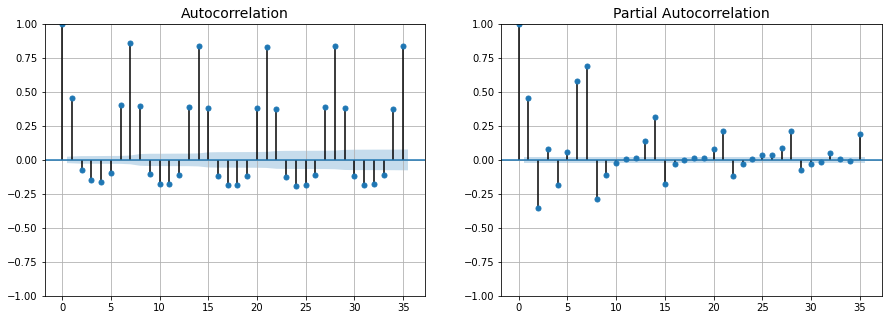

In [19]:
# extra code – shows how to plot the Autocorrelation Function (ACF) and the
#              Partial Autocorrelation Function (PACF)

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
plot_acf(df[period]["rail"], ax=axs[0], lags=35)
axs[0].grid()
plot_pacf(df[period]["rail"], ax=axs[1], lags=35, method="ywm")
axs[1].grid()
plt.show()

In [20]:
import tensorflow as tf

my_series = [0, 1, 2, 3, 4, 5]
my_dataset = tf.keras.utils.timeseries_dataset_from_array(
    my_series,
    targets=my_series[3:],  # the targets are 3 steps into the future
    sequence_length=3,
    batch_size=2
)
list(my_dataset)

[(<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[0, 1, 2],
         [1, 2, 3]], dtype=int32)>,
  <tf.Tensor: shape=(2,), dtype=int32, numpy=array([3, 4], dtype=int32)>),
 (<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[2, 3, 4]], dtype=int32)>,
  <tf.Tensor: shape=(1,), dtype=int32, numpy=array([5], dtype=int32)>)]

In [21]:
for window_dataset in tf.data.Dataset.range(6).window(4, shift=1):
    for element in window_dataset:
        print(f"{element}", end=" ")
    print()

0 1 2 3 
1 2 3 4 
2 3 4 5 
3 4 5 
4 5 
5 


In [22]:
dataset = tf.data.Dataset.range(6).window(4, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window_dataset: window_dataset.batch(4))
for window_tensor in dataset:
    print(f"{window_tensor}")

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


[0 1 2 3]
[1 2 3 4]
[2 3 4 5]


In [23]:
def to_windows(dataset, length):
    dataset = dataset.window(length, shift=1, drop_remainder=True)
    return dataset.flat_map(lambda window_ds: window_ds.batch(length))

dataset = to_windows(tf.data.Dataset.range(6), 4)
dataset = dataset.map(lambda window: (window[:-1], window[-1]))
list(dataset.batch(2))

[(<tf.Tensor: shape=(2, 3), dtype=int64, numpy=
  array([[0, 1, 2],
         [1, 2, 3]])>,
  <tf.Tensor: shape=(2,), dtype=int64, numpy=array([3, 4])>),
 (<tf.Tensor: shape=(1, 3), dtype=int64, numpy=array([[2, 3, 4]])>,
  <tf.Tensor: shape=(1,), dtype=int64, numpy=array([5])>)]

In [24]:
rail_train = df["rail"]["2016-01":"2018-12"] / 1e6
rail_valid = df["rail"]["2019-01":"2019-05"] / 1e6
rail_test = df["rail"]["2019-06":] / 1e6

In [25]:
seq_length = 56
tf.random.set_seed(42)  # extra code – ensures reproducibility
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),
    targets=rail_train[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_valid.to_numpy(),
    targets=rail_valid[seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

In [26]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[seq_length])
])
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae", patience=50, restore_best_weights=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
history = model.fit(train_ds, validation_data=valid_ds, epochs=500,
                    callbacks=[early_stopping_cb])

Epoch 1/500
33/33 [==============================] - 3s 32ms/step - loss: 0.0244 - mae: 0.1757 - val_loss: 0.0076 - val_mae: 0.0968
Epoch 2/500
33/33 [==============================] - 1s 12ms/step - loss: 0.0106 - mae: 0.1101 - val_loss: 0.0056 - val_mae: 0.0780
Epoch 3/500
33/33 [==============================] - 1s 14ms/step - loss: 0.0081 - mae: 0.0945 - val_loss: 0.0051 - val_mae: 0.0750
Epoch 4/500
33/33 [==============================] - 1s 13ms/step - loss: 0.0074 - mae: 0.0896 - val_loss: 0.0053 - val_mae: 0.0768
Epoch 5/500
33/33 [==============================] - 1s 19ms/step - loss: 0.0067 - mae: 0.0848 - val_loss: 0.0049 - val_mae: 0.0722
Epoch 6/500
33/33 [==============================] - 1s 20ms/step - loss: 0.0063 - mae: 0.0821 - val_loss: 0.0043 - val_mae: 0.0665
Epoch 7/500
33/33 [==============================] - 1s 18ms/step - loss: 0.0064 - mae: 0.0828 - val_loss: 0.0042 - val_mae: 0.0650
Epoch 8/500
33/33 [==============================] - 1s 14ms/step - loss: 0.

In [27]:
# extra code – evaluates the model
valid_loss, valid_mae = model.evaluate(valid_ds)
valid_mae * 1e6

3/3 [==============================] - 0s 11ms/step - loss: 0.0023 - mae: 0.0380


37989.10602927208

**Using Simple RNN**

In [28]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

In [29]:
# extra code – defines a utility function we'll reuse several time

def fit_and_evaluate(model, train_set, valid_set, learning_rate, epochs=500):
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae", patience=50, restore_best_weights=True)
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
    history = model.fit(train_set, validation_data=valid_set, epochs=epochs,
                        callbacks=[early_stopping_cb])
    valid_loss, valid_mae = model.evaluate(valid_set)
    return valid_mae * 1e6

In [30]:
# extra code – defines a utility function we'll reuse several time

def fit_and_evaluate(model, train_set, valid_set, learning_rate, epochs=500):
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae", patience=50, restore_best_weights=True)
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
    history = model.fit(train_set, validation_data=valid_set, epochs=epochs,
                        callbacks=[early_stopping_cb])
    valid_loss, valid_mae = model.evaluate(valid_set)
    return valid_mae * 1e6

**Univariate Time Series**

In [31]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
univar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 1]),
    tf.keras.layers.Dense(1)  # no activation function by default
])

In [32]:
# extra code – compiles, fits, and evaluates the model, like earlier
fit_and_evaluate(univar_model, train_ds, valid_ds, learning_rate=0.05)

Epoch 1/500
33/33 [==============================] - 2s 27ms/step - loss: 0.0227 - mae: 0.1621 - val_loss: 0.0054 - val_mae: 0.0869
Epoch 2/500
33/33 [==============================] - 1s 19ms/step - loss: 0.0054 - mae: 0.0750 - val_loss: 0.0041 - val_mae: 0.0689
Epoch 3/500
33/33 [==============================] - 1s 20ms/step - loss: 0.0041 - mae: 0.0624 - val_loss: 0.0027 - val_mae: 0.0497
Epoch 4/500
33/33 [==============================] - 1s 20ms/step - loss: 0.0039 - mae: 0.0605 - val_loss: 0.0053 - val_mae: 0.0849
Epoch 5/500
33/33 [==============================] - 1s 29ms/step - loss: 0.0040 - mae: 0.0637 - val_loss: 0.0021 - val_mae: 0.0382
Epoch 6/500
33/33 [==============================] - 1s 30ms/step - loss: 0.0033 - mae: 0.0524 - val_loss: 0.0021 - val_mae: 0.0368
Epoch 7/500
33/33 [==============================] - 1s 24ms/step - loss: 0.0033 - mae: 0.0537 - val_loss: 0.0031 - val_mae: 0.0550
Epoch 8/500
33/33 [==============================] - 1s 19ms/step - loss: 0.

29827.993363142014

**Using DEEP RNN**

In [33]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
deep_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])

In [34]:
# extra code – compiles, fits, and evaluates the model, like earlier
fit_and_evaluate(deep_model, train_ds, valid_ds, learning_rate=0.01)

Epoch 1/500
33/33 [==============================] - 6s 63ms/step - loss: 0.0260 - mae: 0.1696 - val_loss: 0.0102 - val_mae: 0.1010
Epoch 2/500
33/33 [==============================] - 2s 48ms/step - loss: 0.0092 - mae: 0.1086 - val_loss: 0.0046 - val_mae: 0.0799
Epoch 3/500
33/33 [==============================] - 2s 49ms/step - loss: 0.0056 - mae: 0.0797 - val_loss: 0.0032 - val_mae: 0.0631
Epoch 4/500
33/33 [==============================] - 3s 80ms/step - loss: 0.0061 - mae: 0.0831 - val_loss: 0.0032 - val_mae: 0.0618
Epoch 5/500
33/33 [==============================] - 2s 55ms/step - loss: 0.0056 - mae: 0.0789 - val_loss: 0.0026 - val_mae: 0.0526
Epoch 6/500
33/33 [==============================] - 2s 48ms/step - loss: 0.0046 - mae: 0.0656 - val_loss: 0.0022 - val_mae: 0.0456
Epoch 7/500
33/33 [==============================] - 2s 48ms/step - loss: 0.0044 - mae: 0.0646 - val_loss: 0.0021 - val_mae: 0.0416
Epoch 8/500
33/33 [==============================] - 2s 49ms/step - loss: 0.

30833.231285214424

**Let's forecast Several steps ahead of time**

In [35]:
import numpy as np

X = rail_valid.to_numpy()[np.newaxis, :seq_length, np.newaxis]
for step_ahead in range(14):
    y_pred_one = univar_model.predict(X)
    X = np.concatenate([X, y_pred_one.reshape(1, 1, 1)], axis=1)

1/1 [==============================] - 0s 34ms/step


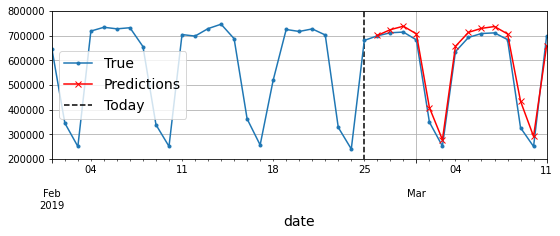

In [36]:
# extra code – generates and saves Figure 15–11

# The forecasts start on 2019-02-26, as it is the 57th day of 2019, and they end
# on 2019-03-11. That's 14 days in total.
Y_pred = pd.Series(X[0, -14:, 0],
                   index=pd.date_range("2019-02-26", "2019-03-11"))

fig, ax = plt.subplots(figsize=(8, 3.5))
(rail_valid * 1e6)["2019-02-01":"2019-03-11"].plot(
    label="True", marker=".", ax=ax)
(Y_pred * 1e6).plot(
    label="Predictions", grid=True, marker="x", color="r", ax=ax)
ax.vlines("2019-02-25", 0, 1e6, color="k", linestyle="--", label="Today")
ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")
save_fig("forecast_ahead_plot")
plt.show()

**Multivariate Time Series**

In [40]:
df_mulvar = df[["bus", "rail"]] / 1e6  # use both bus & rail series as input
df_mulvar["next_day_type"] = df["day_type"].shift(-1)  # we know tomorrow's type
df_mulvar = pd.get_dummies(df_mulvar)  # one-hot encode the day type

In [41]:
mulvar_train = df_mulvar["2016-01":"2018-12"]
mulvar_valid = df_mulvar["2019-01":"2019-05"]
mulvar_test = df_mulvar["2019-06":]

In [45]:
tf.random.set_seed(42)  # extra code – ensures reproducibility

train_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),  # use all 5 columns as input
    targets=mulvar_train["rail"][seq_length:],  # forecast only the rail series
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=mulvar_valid["rail"][seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

In [47]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
mulvar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(1)
])

In [48]:
# extra code – compiles, fits, and evaluates the model, like earlier
fit_and_evaluate(mulvar_model, train_mulvar_ds, valid_mulvar_ds,
                 learning_rate=0.05)

Epoch 1/500
33/33 [==============================] - 6s 43ms/step - loss: 0.0793 - mae: 0.2528 - val_loss: 0.0013 - val_mae: 0.0417
Epoch 2/500
33/33 [==============================] - 1s 21ms/step - loss: 0.0024 - mae: 0.0504 - val_loss: 0.0021 - val_mae: 0.0555
Epoch 3/500
33/33 [==============================] - 1s 22ms/step - loss: 0.0019 - mae: 0.0438 - val_loss: 8.8185e-04 - val_mae: 0.0324
Epoch 4/500
33/33 [==============================] - 1s 20ms/step - loss: 0.0016 - mae: 0.0400 - val_loss: 8.2795e-04 - val_mae: 0.0311
Epoch 5/500
33/33 [==============================] - 1s 21ms/step - loss: 0.0015 - mae: 0.0376 - val_loss: 0.0012 - val_mae: 0.0402
Epoch 6/500
33/33 [==============================] - 1s 19ms/step - loss: 0.0014 - mae: 0.0363 - val_loss: 6.3320e-04 - val_mae: 0.0259
Epoch 7/500
33/33 [==============================] - 1s 25ms/step - loss: 0.0013 - mae: 0.0360 - val_loss: 7.0418e-04 - val_mae: 0.0272
Epoch 8/500
33/33 [==============================] - 1s 32ms

23347.025737166405

In [49]:
tf.random.set_seed(42)  # extra code – ensures reproducibility

def split_inputs_and_targets(mulvar_series, ahead=14, target_col=1):
    return mulvar_series[:, :-ahead], mulvar_series[:, -ahead:, target_col]

ahead_train_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),
    targets=None,
    sequence_length=seq_length + 14,
    batch_size=32,
    shuffle=True,
    seed=42
).map(split_inputs_and_targets)
ahead_valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=None,
    sequence_length=seq_length + 14,
    batch_size=32
).map(split_inputs_and_targets)

In [50]:
tf.random.set_seed(42)

ahead_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

In [51]:
# extra code – compiles, fits, and evaluates the model, like earlier
fit_and_evaluate(ahead_model, ahead_train_ds, ahead_valid_ds,
                 learning_rate=0.02)

Epoch 1/500
33/33 [==============================] - 2s 28ms/step - loss: 0.1433 - mae: 0.4086 - val_loss: 0.0369 - val_mae: 0.2009
Epoch 2/500
33/33 [==============================] - 1s 19ms/step - loss: 0.0239 - mae: 0.1739 - val_loss: 0.0165 - val_mae: 0.1433
Epoch 3/500
33/33 [==============================] - 1s 19ms/step - loss: 0.0164 - mae: 0.1464 - val_loss: 0.0128 - val_mae: 0.1258
Epoch 4/500
33/33 [==============================] - 1s 19ms/step - loss: 0.0136 - mae: 0.1331 - val_loss: 0.0106 - val_mae: 0.1124
Epoch 5/500
33/33 [==============================] - 1s 18ms/step - loss: 0.0120 - mae: 0.1232 - val_loss: 0.0097 - val_mae: 0.1067
Epoch 6/500
33/33 [==============================] - 1s 19ms/step - loss: 0.0108 - mae: 0.1148 - val_loss: 0.0083 - val_mae: 0.0988
Epoch 7/500
33/33 [==============================] - 1s 29ms/step - loss: 0.0098 - mae: 0.1085 - val_loss: 0.0074 - val_mae: 0.0932
Epoch 8/500
33/33 [==============================] - 1s 28ms/step - loss: 0.

34240.7152056694

In [55]:
X = mulvar_valid.to_numpy()[np.newaxis, :seq_length]  # shape [1, 56, 5]
Y_pred = ahead_model.predict(X)  # shape [1, 14]

1/1 [==============================] - 0s 406ms/step


In [56]:
my_series = tf.data.Dataset.range(7)
dataset = to_windows(to_windows(my_series, 3), 4)
list(dataset)

[<tf.Tensor: shape=(4, 3), dtype=int64, numpy=
 array([[0, 1, 2],
        [1, 2, 3],
        [2, 3, 4],
        [3, 4, 5]])>, <tf.Tensor: shape=(4, 3), dtype=int64, numpy=
 array([[1, 2, 3],
        [2, 3, 4],
        [3, 4, 5],
        [4, 5, 6]])>]

In [ ]:
my_series = tf.data.Dataset.range(7)
dataset = to_windows(to_windows(my_series, 3), 4)
list(dataset)

In [58]:
def to_seq2seq_dataset(series, seq_length=56, ahead=14, target_col=1,
                       batch_size=32, shuffle=False, seed=None):
    ds = to_windows(tf.data.Dataset.from_tensor_slices(series), ahead + 1)
    ds = to_windows(ds, seq_length).map(lambda S: (S[:, 0], S[:, 1:, 1]))
    if shuffle:
        ds = ds.shuffle(8 * batch_size, seed=seed)
    return ds.batch(batch_size)

seq2seq_train = to_seq2seq_dataset(mulvar_train, shuffle=True, seed=42)
seq2seq_valid = to_seq2seq_dataset(mulvar_valid)

tf.random.set_seed(42)  # extra code – ensures reproducibility
seq2seq_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
    # equivalent: tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(14))
    # also equivalent: tf.keras.layers.Conv1D(14, kernel_size=1)
])

fit_and_evaluate(seq2seq_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1)

Epoch 1/500
33/33 [==============================] - 8s 65ms/step - loss: 0.0624 - mae: 0.2594 - val_loss: 0.0169 - val_mae: 0.1399
Epoch 2/500
33/33 [==============================] - 2s 41ms/step - loss: 0.0118 - mae: 0.1171 - val_loss: 0.0095 - val_mae: 0.0999
Epoch 3/500
33/33 [==============================] - 2s 41ms/step - loss: 0.0079 - mae: 0.0920 - val_loss: 0.0079 - val_mae: 0.0891
Epoch 4/500
33/33 [==============================] - 1s 26ms/step - loss: 0.0067 - mae: 0.0812 - val_loss: 0.0068 - val_mae: 0.0808
Epoch 5/500
33/33 [==============================] - 1s 27ms/step - loss: 0.0060 - mae: 0.0752 - val_loss: 0.0058 - val_mae: 0.0730
Epoch 6/500
33/33 [==============================] - 1s 26ms/step - loss: 0.0056 - mae: 0.0717 - val_loss: 0.0060 - val_mae: 0.0754
Epoch 7/500
33/33 [==============================] - 1s 34ms/step - loss: 0.0052 - mae: 0.0684 - val_loss: 0.0053 - val_mae: 0.0689
Epoch 8/500
33/33 [==============================] - 3s 81ms/step - loss: 0.

46593.956649303436

**LSTM - Long Short Term Memory**

In [59]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

In [60]:
fit_and_evaluate(lstm_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5
33/33 [==============================] - 5s 74ms/step - loss: 0.0595 - mae: 0.2610 - val_loss: 0.0183 - val_mae: 0.1647
Epoch 2/5
33/33 [==============================] - 2s 58ms/step - loss: 0.0166 - mae: 0.1561 - val_loss: 0.0171 - val_mae: 0.1457
Epoch 3/5
33/33 [==============================] - 1s 40ms/step - loss: 0.0152 - mae: 0.1506 - val_loss: 0.0164 - val_mae: 0.1410
Epoch 4/5
33/33 [==============================] - 1s 40ms/step - loss: 0.0145 - mae: 0.1463 - val_loss: 0.0157 - val_mae: 0.1377
Epoch 5/5
3/3 [==============================] - 0s 41ms/step - loss: 0.0152 - mae: 0.1338


133778.78069877625

**GRU Layer**

In [61]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
gru_model = tf.keras.Sequential([
    tf.keras.layers.GRU(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])


In [62]:
fit_and_evaluate(gru_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5
33/33 [==============================] - 7s 122ms/step - loss: 0.0556 - mae: 0.2578 - val_loss: 0.0201 - val_mae: 0.1639
Epoch 2/5
33/33 [==============================] - 2s 43ms/step - loss: 0.0154 - mae: 0.1447 - val_loss: 0.0150 - val_mae: 0.1345
Epoch 3/5
33/33 [==============================] - 2s 44ms/step - loss: 0.0127 - mae: 0.1321 - val_loss: 0.0136 - val_mae: 0.1261
Epoch 4/5
33/33 [==============================] - 2s 67ms/step - loss: 0.0117 - mae: 0.1252 - val_loss: 0.0127 - val_mae: 0.1220
Epoch 5/5
3/3 [==============================] - 0s 32ms/step - loss: 0.0121 - mae: 0.1190


118994.41480636597